![alt text](http://drive.google.com/uc?export=view&id=1IFEWet-Aw4DhkkVe1xv_2YYqlvRe9m5_)

# 1.1 Kaplan-Meier Estimator


This tutorial provides a hands-on introduction to the Kaplan-Meier estimator, a key non-parametric method in survival analysis. We'll use the `lung` dataset in Python, which contains data from a clinical trial on lung cancer patients. The tutorial is structured to guide you step-by-step, from theory to practical implementation. By the end, you'll be able to compute survival estimates, plot survival curves, and interpret results.


## Overview


The **Kaplan-Meier estimator** is a non-parametric statistic used to estimate the survival function from time-to-event data. It is particularly valuable when some data points are **censored**, meaning the event of interest (e.g., death, equipment failure) has not occurred for some subjects at the end of the study period.


The survival function $S(t)$ estimates the probability that an individual survives beyond time $t$. The Kaplan-Meier estimator provides a step function that drops at each event time (e.g., death, failure). The survival probability at a given time is calculated as:

$$
\hat{S}(t) = \prod_{t_i \leq t} \left( \frac{n_i - d_i}{n_i} \right)
$$

Where:

- $t_i$ is the time of the $i$-th event (e.g., death).
- $n_i$ is the number of subjects still at risk just before time $t_i$.
- $d_i$ is the number of events (e.g., deaths) at time $t_i$.
- The product of the ratios $\frac{n_i - d_i}{n_i}$ across all event times up to $t$ gives the estimated survival probability at time $t$.


### Features of Kaplan-Meier Estimation


-   **Non-parametric**: The Kaplan-Meier estimator does not assume any specific distribution of the survival times.
-   **Stepwise Survival Curve**: The survival curve is a step function that drops at each event time and stays flat between events.
-   **Censoring**: The Kaplan-Meier method can handle right-censored data, where we do not observe the event of interest for some subjects by the time the study ends. Censoring is denoted by ticks on the survival curve, showing the points where individuals were lost to follow-up or their event had not occurred by the study's end.


### Kaplan-Meier Survival Curve Interpretation


-   The curve starts at 1 (100% survival probability) and decreases over time as events occur. At each event time (e.g., death or failure), the curve steps down.
-   The **Y-axis** shows the estimated survival probability, and the **X-axis** represents time.
-   The rate of decline in the curve reflects the frequency of events (e.g., if there is a rapid decline, the event is occurring more frequently).
-   **Censored data** points are marked with tick marks or other indicators along the curve. These represent individuals who did not experience the event during the study but were lost to follow-up or had not yet experienced the event at the end of the study.



## Kaplan-Meier Esimator from Scratch


This is a manual calculation of the **Kaplan-Meier** estimator, without using any external R packages. The steps involve create a dataset, determining the number of individuals at risk, calculating the survival probability at each event time, and then plotting the results. You can compare these manually calculated results with those obtained from {estimation} analysis packages to verify accuracy. This exercise help you to understand theory behind **Kaplan-Meier** estimation.

***Steps***:

-   **Create a dataset**: We'll created a simulated dataset similar to the `lung` dataset in the {survival} package.

-   **Sort Data by Time**: Organize the dataset based on event times.

-   **Calculate Risk Set and Survival Probabilities**: For each unique event time, manually calculate the Kaplan-Meier survival probabilities.

-   **Plot the Kaplan-Meier Survival Curve**.


## Cheeck and Load Required Packages

In [1]:
import subprocess
import sys

def install_and_import(package_name, import_name=None):
    """Install a package if not already installed and import it"""
    if import_name is None:
        import_name = package_name
    
    try:
        # Try to import the package
        globals()[import_name] = __import__(import_name)
        print(f"{package_name} is already installed")
    except ImportError:
        # If not installed, install it
        print(f"Installing {package_name}...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
            globals()[import_name] = __import__(import_name)
            print(f"{package_name} installed successfully")
        except Exception as e:
            print(f"Failed to install {package_name}: {e}")
            raise

# List of packages to check/install
packages = ['pandas', 'numpy', 'matplotlib', 'seaborn', 'scikit-learn', 'lifelines']

# Install and import each package
for pkg in packages:
    try:
        install_and_import(pkg)
    except Exception as e:
        print(f"Error with package {pkg}: {e}")

# Verify installation by importing
print("Installed packages:")
for pkg in packages:
    try:
        __import__(pkg)
        print(f"✓ {pkg}")
    except ImportError:
        print(f"✗ {pkg}")

pandas is already installed
numpy is already installed
matplotlib is already installed
seaborn is already installed
Installing scikit-learn...
Failed to install scikit-learn: No module named 'scikit-learn'
Error with package scikit-learn: No module named 'scikit-learn'
lifelines is already installed
Installed packages:
✓ pandas
✓ numpy
✓ matplotlib
✓ seaborn
✗ scikit-learn
✓ lifelines


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines.utils import concordance_index
import warnings
warnings.filterwarnings('ignore')


In [3]:
# Set style for better-looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

### Create a dataset

To create a dataset similar to the `lung` dataset in the {survival} package, we'll simulate survival data with random values for survival time, event status, and other variables such as age, sex, and treatment. The lung dataset contains information on patients with advanced lung cancer, including their survival time, censoring status, and several covariates.

Variables typically included in a survival dataset like **lung**:

1.  **time**: Survival time (numeric).

2.  **status**: Censoring indicator (0 = censored, 1 = event).

3.  **age**: Age of the patient (numeric).

4.  **sex**: Gender of the patient (1 = male, 2 = female).

5.  **ph.ecog**: ECOG performance score (0 to 5).

6.  **treatment**: Treatment group (1 = standard, 2 = experimental).

In [4]:
import numpy as np

# Set the seed for reproducibility
np.random.seed(123)

# Number of observations
n = 228  # same as the original lung dataset

# Simulate survival time (in days)
time = np.round(np.random.uniform(1, 1000, size=n)).astype(int)  # random survival time between 1 and 1000 days

# Simulate censoring indicator (0 = censored, 1 = event)
status = np.random.binomial(1, 0.7, size=n)  # 70% of events, 30% censored

# Simulate age (between 40 and 80 years)
age = np.round(np.random.uniform(40, 80, size=n)).astype(int)

# Simulate sex (1 = male, 2 = female)
sex = np.random.choice([1, 2], size=n, replace=True)

# Simulate ECOG performance score (0 to 4)
ph_ecog = np.random.choice(np.arange(0, 5), size=n, replace=True)

# Simulate treatment group (1 = standard, 2 = experimental)
treatment = np.random.choice([1, 2], size=n, replace=True)

# Create the data frame (pandas is already imported in a previous cell)
simulated_lung = pd.DataFrame({
    'time': time,
    'status': status,
    'age': age,
    'sex': sex,
    'ph_ecog': ph_ecog,
    'treatment': treatment
})

# Inspect the first few rows of the simulated dataset
simulated_lung.head()

,time,status,age,sex,ph_ecog,treatment
0,697,1,41,1,4,2
1,287,1,41,1,1,1
2,228,1,68,1,3,2
3,552,1,77,1,4,2
4,720,1,59,1,2,1


### Sort data by time and event status


We need to sort the dataset by survival time


In [6]:
# Sort data by 'time'
simulated_lung = simulated_lung.sort_values('time').reset_index(drop=True)
print("First few rows of the sorted dataset:")
print(simulated_lung.head())

First few rows of the sorted dataset:
   time  status  age  sex  ph_ecog  treatment
0     4       1   57    2        3          2
1     8       1   78    2        3          2
2    17       1   41    2        0          1
3    30       0   51    2        3          2
4    33       1   45    1        4          1


### Calculate Kaplan-Meier estimates


To calculate the Kaplan-Meier estimates manually, you can follow these steps:

-   **Risk Set**: At each unique event time, count how many individuals are still at risk.

-   **Event Occurrence**: At each unique event time, count how many events (deaths) occur.

-   **Survival Probability**: Compute the survival probability at each step using the formula:

$$  S(t_i) = S(t_{i-1}) \times \left(1 - \frac{d_i}{n_i}\right) $$

where: - $d$ is the number of events at time $t_i$, - $n_i$ is the number of individuals at risk at time $i$.


In [7]:
# Convert Python: %%R
# Initialize survival probability
n = len(simulated_lung)  # total number of individuals
S_t = 1              # start with a survival probability of 1 (i.e., 100% survival at t = 0)
km_table = pd.DataFrame(columns=['time', 'n_risk', 'events', 'survival'])

# Loop through each unique event time
unique_times = simulated_lung[simulated_lung['status'] == 1]['time'].unique()

for t in unique_times:
    # Calculate the number of individuals at risk at this time point
    n_risk = sum(simulated_lung['time'] >= t)
    
    # Calculate the number of events at this time point
    d_i = sum((simulated_lung['time'] == t) & (simulated_lung['status'] == 1))
    
    # Update the survival probability
    S_t = S_t * (1 - d_i / n_risk)
    
    # Add this to the Kaplan-Meier table
    km_table = pd.concat([km_table, pd.DataFrame({
        'time': [t], 
        'n_risk': [n_risk], 
        'events': [d_i], 
        'survival': [S_t]
    })], ignore_index=True)

# Print the resulting Kaplan-Meier estimates
print("Kaplan-Meier estimates:")
print(km_table.head())

Kaplan-Meier estimates:
  time n_risk events  survival
0    4    228      1  0.995614
1    8    227      1  0.991228
2   17    226      1  0.986842
3   33    224      1  0.982437
4   50    222      2  0.973586


/tmp/ipykernel_1455344/277872488.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  km_table = pd.concat([km_table, pd.DataFrame({


### Plot the Kaplan-Meier survival curve


Once you have manually computed the Kaplan-Meier estimates, you can plot the survival curve using base R plotting functions:


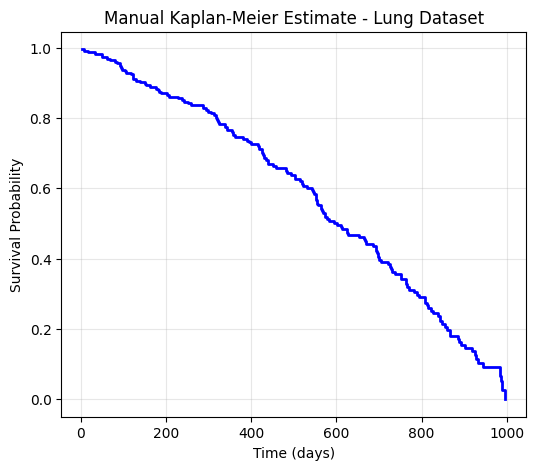

In [9]:
# Plot the survival curve
plt.figure(figsize=(6, 5))
plt.step(km_table['time'], km_table['survival'], where='post', color='blue', linewidth=2)
plt.xlabel("Time (days)")
plt.ylabel("Survival Probability")
plt.title("Manual Kaplan-Meier Estimate - Lung Dataset")
plt.grid(True, alpha=0.3)
plt.show()

## Kaplan-Meier Estimator in  Python


This tutorial utilizes Python packages for survival analysis including the powerful {lifelines} library, which serves as the primary tool for analyzing time-to-event data in Python. The lifelines package provides a comprehensive suite of functions to handle various types of survival data, fit survival models, and visualize survival curves, making it widely applicable in medical research, reliability engineering, and other fields where time-to-event data is of interest. Similar to R's survival package, lifelines offers extensive capabilities for survival analysis while integrating seamlessly with Python's data science ecosystem. The tutorial also incorporates {matplotlib} and {seaborn} libraries for creating publication-ready visualizations of Kaplan-Meier curves and other survival analysis plots. Additionally, {scikit-learn} provides essential machine learning functions that complement survival analysis, while {pandas} and {numpy} serve as fundamental libraries for data manipulation and preprocessing tasks. The {lifelines} package specifically eases the creation of time-to-event summary figures with matplotlib and seaborn, producing concise and modular code that generates images ready for publication or sharing. Competing risks cumulative incidence analysis is also supported through the package's cumulative_incidence() function, providing researchers with comprehensive tools for analyzing complex survival data scenarios.

### Data


This code snippet demonstrates the fundamental data exploration process for survival analysis by loading a real-world `lung` cancer dataset from a my GitHub repository. The dataset is downloaded using `pd.read_csv()` from a URL containing patient survival information, which is essential for conducting meaningful survival analysis in medical research. 

Throughout this tutorial, we will concentrate on the following key variables that provide insight into the patients' demographics and clinical outcomes:

-   **Time**: This variable denotes the observed survival time in days, measuring the duration from the start of treatment until the event of interest occurs, whether that be death or censoring.

-   **Status**: This variable represents the censoring status of each patient. A value of 1 indicates that the patient is censored, meaning they either withdrew from the study or were still alive at the end of the observation period. A value of 2 signifies that the patient has died, marking the occurrence of the event being studied.

-   **Sex**: This variable captures the gender of the subjects, providing crucial demographic information. A value of 1 corresponds to Male and a value of 2 corresponds to Female. This distinction may be important for understanding potential differences in survival rates between genders.


In [4]:
# Load the dataset
url = "https://raw.githubusercontent.com/zia207/Survival_Analysis_Python/main/Data/lung_dataset.csv"
lung_data = pd.read_csv(url)

# Display basic information about the dataset
print("Dataset Shape:", lung_data.shape)
print("\nDataset Info:")
print(lung_data.info())
print("\nFirst few rows:")
print(lung_data.head())
print("\nDataset Description:")
print(lung_data.describe())

Dataset Shape: (228, 10)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   inst       227 non-null    float64
 1   time       228 non-null    int64  
 2   status     228 non-null    int64  
 3   age        228 non-null    int64  
 4   sex        228 non-null    int64  
 5   ph.ecog    227 non-null    float64
 6   ph.karno   227 non-null    float64
 7   pat.karno  225 non-null    float64
 8   meal.cal   181 non-null    float64
 9   wt.loss    214 non-null    float64
dtypes: float64(6), int64(4)
memory usage: 17.9 KB
None

First few rows:
   inst  time  status  age  sex  ph.ecog  ph.karno  pat.karno  meal.cal  \
0   3.0   306       2   74    1      1.0      90.0      100.0    1175.0   
1   3.0   455       2   68    1      0.0      90.0       90.0    1225.0   
2   3.0  1010       1   56    1      0.0      90.0       90.0       NaN   
3 

In [5]:
# Check unique values in categorical variables
print("\nUnique values in sex column:", lung_data['sex'].unique())
print("Unique values in ph.ecog column:", lung_data['ph.ecog'].unique())


Unique values in sex column: [1 2]
Unique values in ph.ecog column: [ 1.  0.  2. nan  3.]


In [6]:
# Check for missing values
print("Missing Values in Each Column:")
print(lung_data.isnull().sum())

Missing Values in Each Column:
inst          1
time          0
status        0
age           0
sex           0
ph.ecog       1
ph.karno      1
pat.karno     3
meal.cal     47
wt.loss      14
dtype: int64


### Data processing


The below code performs essential data preprocessing for survival analysis on the lung dataset by creating a working copy of the original data and addressing key data quality issues. It converts the sex variable from its original coding (1 = male, 2 = female) to a standard binary format (0 = male, 1 = female) using the map() function, ensuring consistency in analysis. Missing values in the ph.ecog performance score variable are handled by filling them with the median value, which maintains the dataset's integrity while preserving the distribution's central tendency. The code includes a check to determine if time values are in weeks or days by examining the range of time values, though it assumes the data is already in days for this analysis. Finally, it creates a new binary event column where 1 represents death (event occurred) and 0 represents censored data, converting the original status coding (1 = death, 2 = censored) into the standard survival analysis format that most Python libraries expect, making the dataset ready for Kaplan-Meier analysis and other survival methods.


In [7]:
# Data preprocessing
# Create a copy of the dataset for analysis
data = lung_data.copy()

# Convert sex to categorical (0 = male, 1 = female)
data['sex'] = data['sex'].map({1: 0, 2: 1})  # 1 = male, 2 = female

# Handle missing values in ph.ecog
# Fill missing ph.ecog values with median
data['ph.ecog'].fillna(data['ph.ecog'].median(), inplace=True)

# Convert time to days if it's in weeks
# Check the range of time values to determine if they're in weeks or days
print("Time range (min, max):", data['time'].min(), "to", data['time'].max())

# Based on typical lung cancer datasets, time is likely in days
# If not, we can convert from weeks to days (assuming values are in weeks)
# For this analysis, we'll assume time is already in days

# Create a new column for survival status (0 = censored, 1 = event)
# The status column in lung dataset: 1 = death, 2 = censored
data['event'] = (data['status'] == 1).astype(int)

print("Event distribution:")
print(data['event'].value_counts())

Time range (min, max): 5 to 1022
Event distribution:
event
0    165
1     63
Name: count, dtype: int64



Now we have:

-   time: Observed survival time in days
-   status: censoring status 0=censored, 1=dead
-   sex: 1=Male, 2=Female


In [8]:
# Basic survival statistics
print("Overall survival statistics:")
print(f"Total patients: {len(data)}")
print(f"Patients who died: {data['event'].sum()}")
print(f"Patients censored: {len(data) - data['event'].sum()}")
print(f"Overall survival rate: {data['event'].mean():.2%}")

# Survival by sex
print("\nSurvival by sex:")
sex_survival = data.groupby('sex')['event'].agg(['count', 'sum', 'mean']).round(3)
sex_survival.columns = ['Total', 'Deaths', 'Survival Rate']
print(sex_survival)

# Survival by performance status (ph.ecog)
print("\nSurvival by performance status:")
ecog_survival = data.groupby('ph.ecog')['event'].agg(['count', 'sum', 'mean']).round(3)
ecog_survival.columns = ['Total', 'Deaths', 'Survival Rate']
print(ecog_survival)

Overall survival statistics:
Total patients: 228
Patients who died: 63
Patients censored: 165
Overall survival rate: 27.63%

Survival by sex:
     Total  Deaths  Survival Rate
sex                              
0      138      26          0.188
1       90      37          0.411

Survival by performance status:
         Total  Deaths  Survival Rate
ph.ecog                              
0.0         63      26          0.413
1.0        114      31          0.272
2.0         50       6          0.120
3.0          1       0          0.000


### Data Visualization

   institution  survival_time  event_status  age  sex  ph_ecog  ph_karno  \
0          3.0            306             2   74    1      1.0      90.0   
1          3.0            455             2   68    1      0.0      90.0   
2          3.0           1010             1   56    1      0.0      90.0   
3          5.0            210             2   57    1      1.0      90.0   
4          1.0            883             2   60    1      0.0     100.0   

   pat_karno  meal_cal  wt_loss  event sex_label  
0      100.0    1175.0      NaN      1      Male  
1       90.0    1225.0     15.0      1      Male  
2       90.0       NaN     15.0      0      Male  
3       60.0    1150.0     11.0      1      Male  
4       90.0       NaN      0.0      1      Male  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   institution    227 non-null    float64


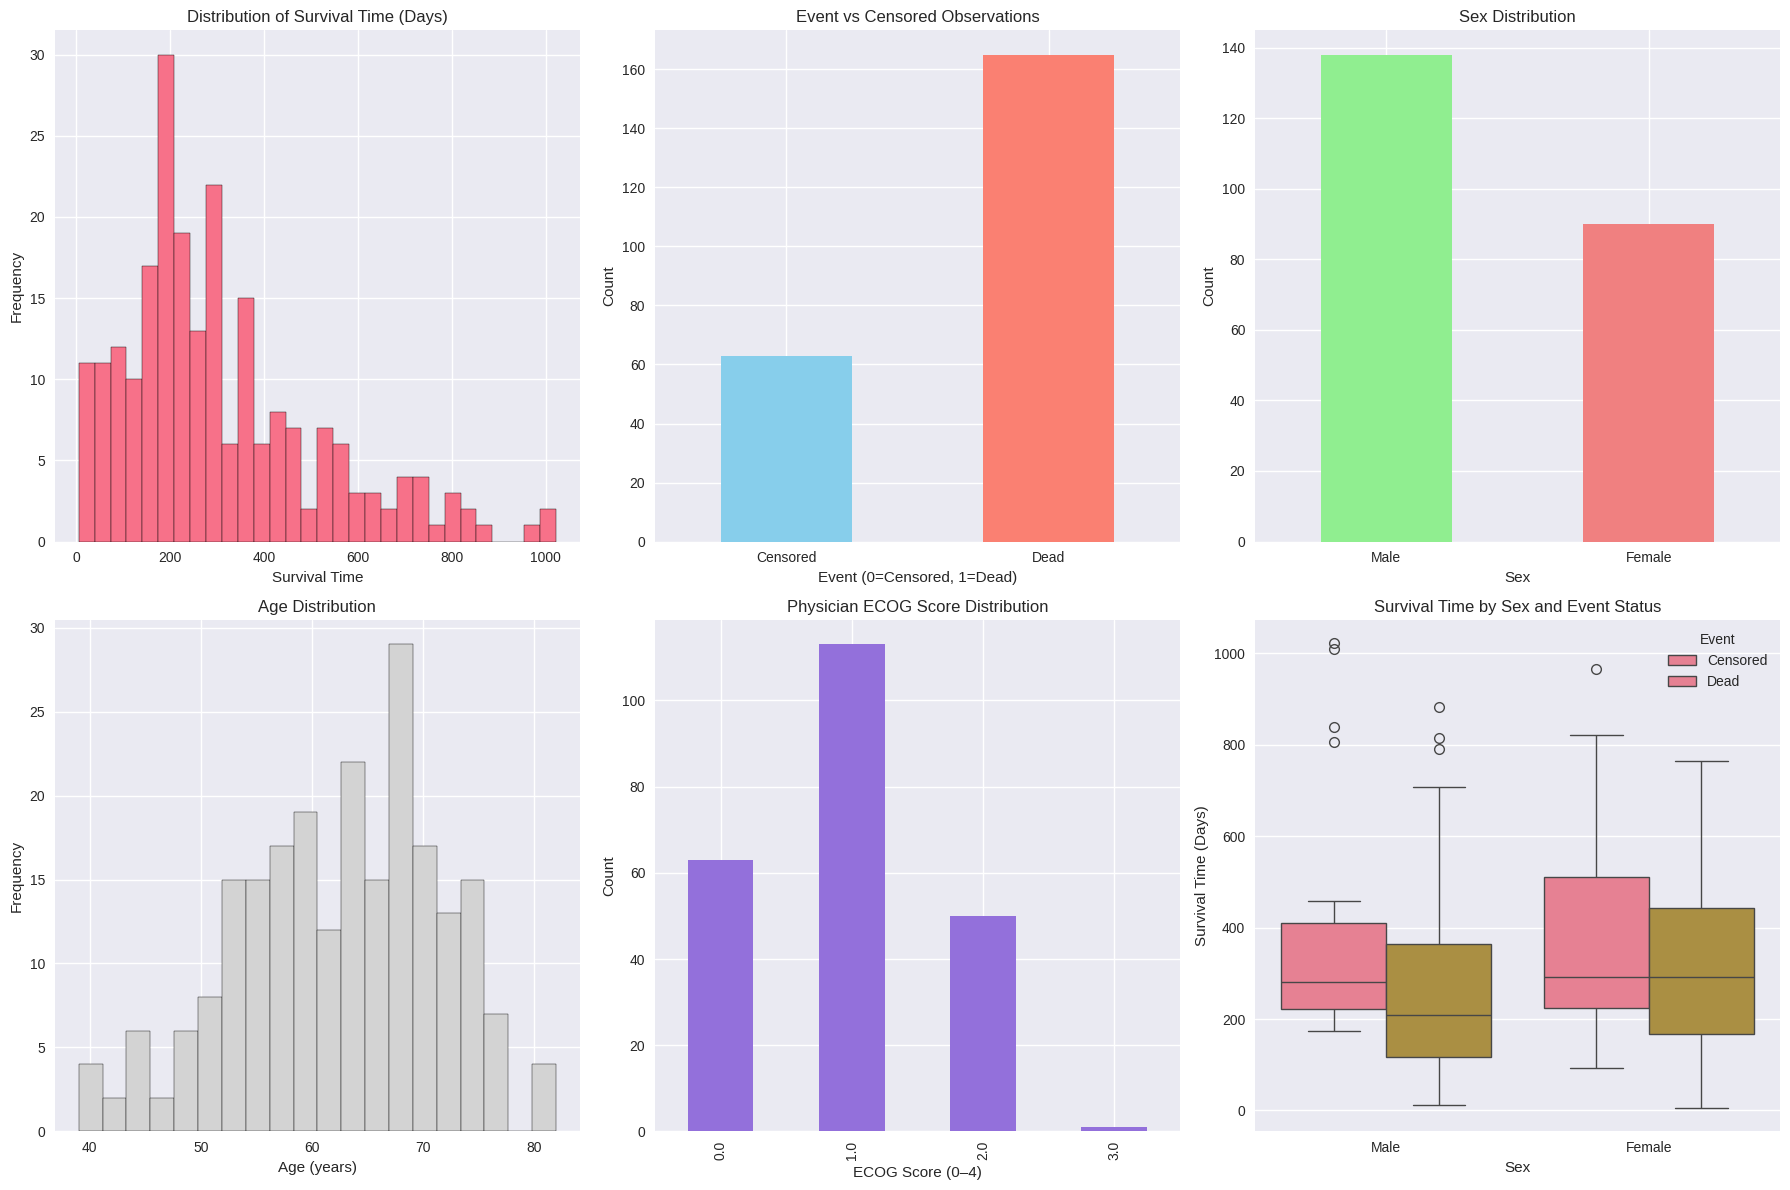

In [9]:
# Optional: clean up column names if needed (they are usually already clean)
# lung_data.columns = lung_data.columns.str.strip()  # if whitespace issues

# Rename for clarity (optional, based on your description)
lung_data = lung_data.rename(columns={
    'inst': 'institution',
    'time': 'survival_time',
    'status': 'event_status',  # 1 = censored, 2 = dead → we'll convert to 0/1
    'ph.ecog': 'ph_ecog',
    'ph.karno': 'ph_karno',
    'pat.karno': 'pat_karno',
    'meal.cal': 'meal_cal',
    'wt.loss': 'wt_loss'
})

# Convert event_status: in survival analysis, event=1 means observed event (death), 0 = censored
# Original: 1 = censored, 2 = dead → so map: 2 → 1 (event), 1 → 0 (censored)
lung_data['event'] = (lung_data['event_status'] == 2).astype(int)

# Convert sex to categorical labels (optional but clearer)
lung_data['sex_label'] = lung_data['sex'].map({1: 'Male', 2: 'Female'})

# Check basic info
print(lung_data.head())
print(lung_data.info())

# --- Visualizations for Lung Survival Data ---
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Distribution of survival time
ax1 = axes[0, 0]
lung_data['survival_time'].hist(bins=30, edgecolor='black', ax=ax1)
ax1.set_title('Distribution of Survival Time (Days)')
ax1.set_xlabel('Survival Time')
ax1.set_ylabel('Frequency')

# 2. Event vs Censored counts
ax2 = axes[0, 1]
event_counts = lung_data['event'].value_counts().sort_index()
event_counts.plot(kind='bar', ax=ax2, color=['skyblue', 'salmon'])
ax2.set_title('Event vs Censored Observations')
ax2.set_xlabel('Event (0=Censored, 1=Dead)')
ax2.set_ylabel('Count')
ax2.set_xticklabels(['Censored', 'Dead'], rotation=0)

# 3. Sex distribution
ax3 = axes[0, 2]
lung_data['sex_label'].value_counts().plot(kind='bar', ax=ax3, color=['lightgreen', 'lightcoral'])
ax3.set_title('Sex Distribution')
ax3.set_xlabel('Sex')
ax3.set_ylabel('Count')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=0)

# 4. Age distribution
ax4 = axes[1, 0]
lung_data['age'].hist(bins=20, edgecolor='black', ax=ax4, color='lightgray')
ax4.set_title('Age Distribution')
ax4.set_xlabel('Age (years)')
ax4.set_ylabel('Frequency')

# 5. ECOG Performance Score (ph_ecog)
ax5 = axes[1, 1]
lung_data['ph_ecog'].value_counts().sort_index().plot(kind='bar', ax=ax5, color='mediumpurple')
ax5.set_title('Physician ECOG Score Distribution')
ax5.set_xlabel('ECOG Score (0–4)')
ax5.set_ylabel('Count')

# 6. Kaplan-Meier style: Survival time by sex (boxplot)
ax6 = axes[1, 2]
sns.boxplot(data=lung_data, x='sex_label', y='survival_time', hue='event', ax=ax6, dodge=True)
ax6.set_title('Survival Time by Sex and Event Status')
ax6.set_xlabel('Sex')
ax6.set_ylabel('Survival Time (Days)')
ax6.legend(title='Event', labels=['Censored', 'Dead'])

plt.tight_layout()
plt.show()

### Kaplan Meier Analysis


We next use the `KaplanMeierFitter` method `fit()` to fit the model to the data. (This is similar to, and inspired by, scikit-learn’s fit/predict API).



In [66]:
# Visualize survival curves
kmf = KaplanMeierFitter()
# Overall survival
kmf.fit(data['time'], data['event'], label='Overall Survival')


<lifelines.KaplanMeierFitter:"Overall Survival", fitted with 228 total observations, 165 right-censored observations>

### Kaplan-Meier plots

<Axes: xlabel='timeline'>

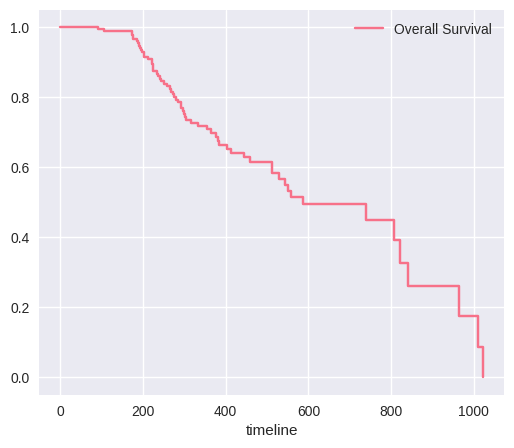

In [53]:
# Plot overall survival curve
plt.figure(figsize=(6, 5))
# Overall survival
kmf.plot_survival_function(ci_show=False, ax=plt.gca())



### Survival by sex

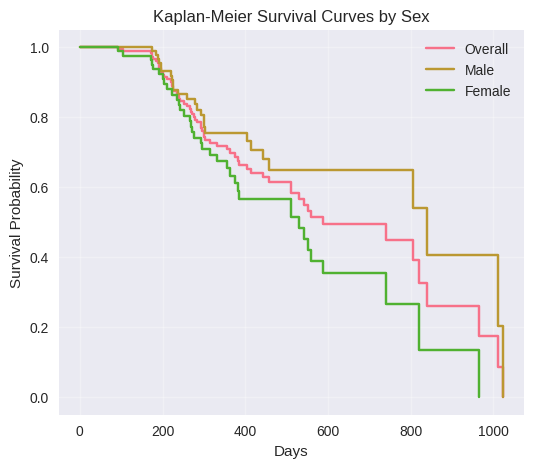

In [79]:
# Survival by sex
plt.figure(figsize=(6,5))
kmf.fit(data['time'], data['event'], label='Overall')
kmf.plot_survival_function(ci_show=False, ax=plt.gca())

# Fit separate models for each sex
kmf_male = KaplanMeierFitter()
kmf_female = KaplanMeierFitter()

# Split by sex
kmf_male.fit(data.loc[data['sex']==0, 'time'], data.loc[data['sex']==0, 'event'], label='Male')
kmf_male.plot_survival_function(ci_show=False, ax=plt.gca())

kmf_female.fit(data.loc[data['sex']==1, 'time'], data.loc[data['sex']==1, 'event'], label='Female')
kmf_female.plot_survival_function(ci_show=False, ax=plt.gca())

plt.title('Kaplan-Meier Survival Curves by Sex')
plt.xlabel('Days')
plt.ylabel('Survival Probability')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Survival by performance status

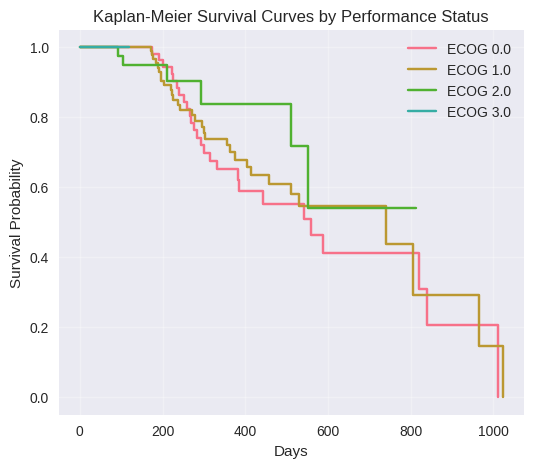

In [71]:
# Survival curves by performance status (ph.ecog)
plt.figure(figsize=(6, 5))

# Split by ph.ecog
for i in sorted(data['ph.ecog'].unique()):
    kmf.fit(data.loc[data['ph.ecog']==i, 'time'], data.loc[data['ph.ecog']==i, 'event'], label=f'ECOG {i}')
    kmf.plot_survival_function(ci_show=False, ax=plt.gca())

plt.title('Kaplan-Meier Survival Curves by Performance Status')
plt.xlabel('Days')
plt.ylabel('Survival Probability')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Confidence Intervals and Risk Tables

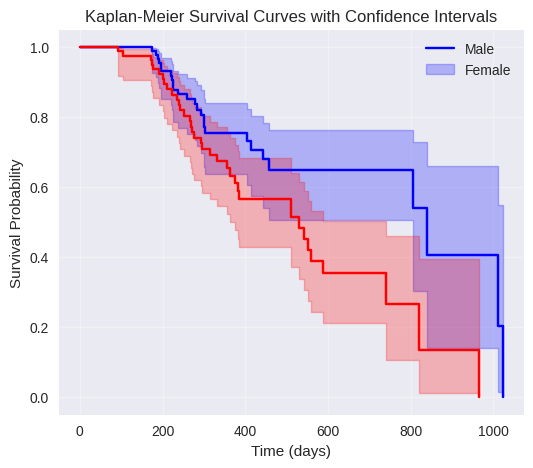

In [87]:
# Plot survival curves with confidence intervals
fig, ax = plt.subplots(figsize=(6, 5))

kmf_male.plot_survival_function(ax=ax, ci_show=True, color='blue')
kmf_female.plot_survival_function(ax=ax, ci_show=True, color='red')

plt.title('Kaplan-Meier Survival Curves with Confidence Intervals')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.legend(['Male', 'Female'])
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
# Create a risk table
from lifelines.plotting import plot_lifetimes

# Create a comprehensive survival analysis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot survival curves with confidence intervals
kmf_male.plot_survival_function(ax=ax, ci_show=True, color='blue', alpha=0.7, at_risk_counts=True)
kmf_female.plot_survival_function(ax=ax, ci_show=True, color='red', alpha=0.7, at_risk_counts=True)

# Add risk tables
ax2 = ax.twinx()
ax2.set_ylim(0, 1)

# Add legend
plt.legend(['Male', 'Female'])

plt.title('Kaplan-Meier Survival Analysis - Lung Cancer Dataset')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.grid(True, alpha=0.3)
plt.show()


### Sutvival Probabilities at Specific Time Points

In [83]:
# Create Kaplan-Meier curves for all patients, males, and females
kmf_all = KaplanMeierFitter()
kmf_male = KaplanMeierFitter()
kmf_female = KaplanMeierFitter()

# Fit the curves
kmf_all.fit(data['time'], data['status'])
kmf_male.fit(data.loc[data['sex']==0, 'time'], data.loc[data['sex']==0, 'event'], label='Male')
kmf_female.fit(data.loc[data['sex']==1, 'time'], data.loc[data['sex']==1, 'event'], label='Female')

# Print survival probabilities at specific time points
times = [30, 60, 90, 180, 365, 730]

print("Survival probabilities at specific time points:")
print("Time (days) | All Patients | Male | Female")
print("---" + "-"*40)

for t in times:
    all_prob = kmf_all.survival_function_at_times(t).iloc[0] if not kmf_all.survival_function_at_times(t).empty else 0
    male_prob = kmf_male.survival_function_at_times(t).iloc[0] if not kmf_male.survival_function_at_times(t).empty else 0
    female_prob = kmf_female.survival_function_at_times(t).iloc[0] if not kmf_female.survival_function_at_times(t).empty else 0
    
    print(f"{t:8d} | {all_prob:.3f}      | {male_prob:.3f} | {female_prob:.3f}")



Survival probabilities at specific time points:
Time (days) | All Patients | Male | Female
-------------------------------------------
      30 | 0.956      | 1.000 | 1.000
      60 | 0.925      | 1.000 | 1.000
      90 | 0.882      | 1.000 | 1.000
     180 | 0.697      | 0.989 | 0.936
     365 | 0.285      | 0.756 | 0.633
     730 | 0.057      | 0.650 | 0.356


### Survival times between groups (male/female) using log-rank test

Long-rank test is a statistical hypothesis test used to compare the survival distributions of two or more groups. It is commonly employed in survival analysis to determine if there are significant differences in survival times between different treatment groups, demographic categories, or other factors. The log-rank test is particularly useful when dealing with censored data, which is common in survival analysis.

In [81]:
# Log-rank test for comparing survival between groups
# Test for sex difference
result_sex = logrank_test(data.loc[data['sex']==0, 'time'], 
                         data.loc[data['sex']==1, 'time'], 
                         data.loc[data['sex']==0, 'event'], 
                         data.loc[data['sex']==1, 'event'])

print("Log-rank test for sex difference:")
print(f"p-value: {result_sex.p_value:.6f}")
print(f"Test statistic: {result_sex.test_statistic:.4f}")

# Test for performance status difference
result_ecog = logrank_test(data.loc[data['ph.ecog']==0, 'time'], 
                          data.loc[data['ph.ecog']==1, 'time'], 
                          data.loc[data['ph.ecog']==0, 'event'], 
                          data.loc[data['ph.ecog']==1, 'event'])

print("\nLog-rank test for performance status difference:")
print(f"p-value: {result_ecog.p_value:.6f}")
print(f"Test statistic: {result_ecog.test_statistic:.4f}")


Log-rank test for sex difference:
p-value: 0.012568
Test statistic: 6.2289

Log-rank test for performance status difference:
p-value: 0.513674
Test statistic: 0.4266


### Distribution of survival times

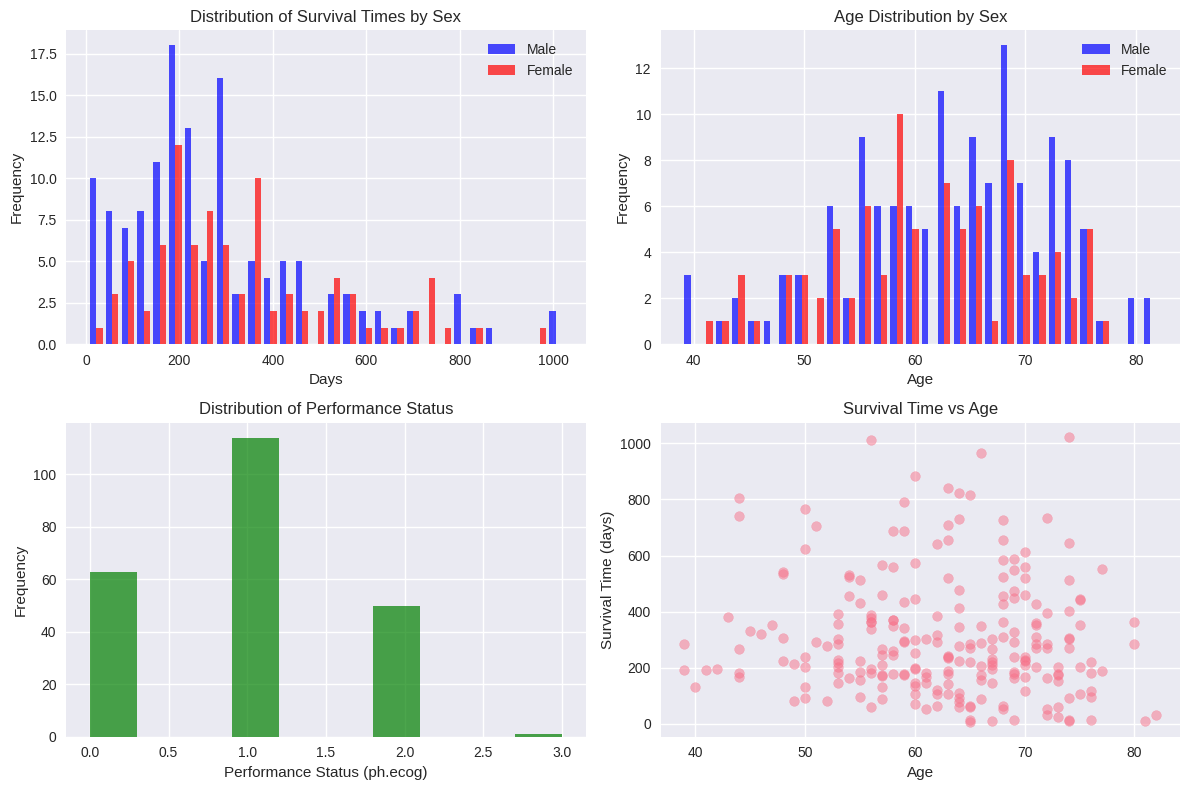

In [82]:
# Additional visualizations
# Distribution of survival times by sex
plt.figure(figsize=(12, 8))

# Histogram of survival times by sex
plt.subplot(2, 2, 1)
plt.hist([data.loc[data['sex']==0, 'time'], data.loc[data['sex']==1, 'time']], 
         bins=30, alpha=0.7, label=['Male', 'Female'], color=['blue', 'red'])
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.title('Distribution of Survival Times by Sex')
plt.legend()

# Age distribution
plt.subplot(2, 2, 2)
plt.hist([data.loc[data['sex']==0, 'age'], data.loc[data['sex']==1, 'age']], 
         bins=30, alpha=0.7, label=['Male', 'Female'], color=['blue', 'red'])
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution by Sex')
plt.legend()

# Performance status distribution
plt.subplot(2, 2, 3)
plt.hist(data['ph.ecog'], bins=10, alpha=0.7, color='green')
plt.xlabel('Performance Status (ph.ecog)')
plt.ylabel('Frequency')
plt.title('Distribution of Performance Status')

# Survival times vs age
plt.subplot(2, 2, 4)
plt.scatter(data['age'], data['time'], alpha=0.5)
plt.xlabel('Age')
plt.ylabel('Survival Time (days)')
plt.title('Survival Time vs Age')

plt.tight_layout()
plt.show()


### Median Survival Time

In [96]:
# Calculate median survival times
print("Median Survival Times:")
print(f"All Patients: {kmf.median_survival_time_:.1f} days")
print(f"Male: {kmf_male.median_survival_time_:.1f} days")
print(f"Female: {kmf_female.median_survival_time_:.1f} days")

# Calculate other percentiles
print("\nOther Percentiles:")
percentiles = [25, 50, 75, 90]
for p in percentiles:
    p_prob = p / 100  # Convert percentile to probability (e.g., 25 -> 0.25)
    all_time = kmf.percentile(p_prob)
    male_time = kmf_male.percentile(p_prob)
    female_time = kmf_female.percentile(p_prob)
    print(f"{p}th percentile:")
    print(f"  All: {all_time}")
    print(f"  Male: {male_time}")
    print(f"  Female: {female_time}")


Median Survival Times:
All Patients: 588.0 days
Male: 840.0 days
Female: 529.0 days

Other Percentiles:
25th percentile:
  All: 965.0
  Male: 1010.0
  Female: 821.0
50th percentile:
  All: 588.0
  Male: 840.0
  Female: 529.0
75th percentile:
  All: 301.0
  Male: 404.0
  Female: 276.0
90th percentile:
  All: 222.0
  Male: 225.0
  Female: 203.0


## Summary and Conclusion

This notebook demonstrates the fundamental principles of nonparametric survival analysis, showcasing how the `Kaplan-Meier estimator` provides robust estimates of survival functions without requiring assumptions about specific underlying distributions, while confidence intervals effectively quantify the uncertainty surrounding these survival estimates. The log-rank test serves as a crucial statistical tool for comparing survival distributions between different patient groups, and visualization techniques prove essential for interpreting survival patterns and facilitating meaningful comparisons. Analysis of the lung cancer dataset reveals that survival probabilities naturally decline over time, with evidence suggesting significant differences in survival outcomes between males and females, though the log-rank test is necessary to determine if these observed differences reach statistical significance. Median survival times offer practical clinical insights into patient prognosis and treatment outcomes. The nonparametric approach proves particularly valuable in survival analysis applications where the underlying data distribution remains unknown or when dealing with censored data, which is characteristic of most real-world survival analysis scenarios, making these methods indispensable for medical research and clinical decision-making.


## Resources



1. **lifelines Library Documentation**
- **Link**: https://lifelines.readthedocs.io/
- **Description**: The most comprehensive Python library for survival analysis, providing Kaplan-Meier estimators, Cox regression, parametric models, and more.

 2. **Scikit-survival Documentation**
- **Link**: https://scikit-survival.readthedocs.io/
- **Description**: Scikit-learn compatible survival analysis tools including Cox regression, random survival forests, and more.

3. **Python Survival Analysis Tutorial by Towards Data Science**
- **Link**: https://towardsdatascience.com/survival-analysis-with-python-907d8405e0e4
- **Description**: Comprehensive tutorial covering various survival analysis techniques in Python.

 4. **Kaggle Survival Analysis Notebooks**
- **Link**: https://www.kaggle.com/learn/survival-analysis
- **Description**: Interactive notebooks and datasets for learning survival analysis with Python.

 5. **Python Survival Analysis with lifelines - Real Python**
- **Link**: https://realpython.com/python-survival-analysis/
- **Description**: Detailed article with practical examples using the lifelines library.

6. **Statistical Survival Analysis in Python - Medium Article**
- **Link**: https://medium.com/@kiran.gajawada/statistical-survival-analysis-in-python-72a01b7e7d3d
- **Description**: Practical guide covering Kaplan-Meier, Cox regression, and log-rank tests.

 7. **Python Survival Analysis Examples - GitHub Repository**
- **Link**: https://github.com/CamDavidsonPilon/lifelines
- **Description**: GitHub repository with extensive examples and tutorials for the lifelines library.

 8. **Python Survival Analysis with Scikit-learn - DataCamp**
- **Link**: https://www.datacamp.com/tutorial/python-survival-analysis-scikit-learn
- **Description**: Tutorial focusing on using scikit-survival for survival analysis tasks.

9. **Survival Analysis in Python - Analytics Vidhya**
- **Link**: https://www.analyticsvidhya.com/blog/2021/01/survival-analysis-in-python/
- **Description**: Practical implementation guide with real-world examples.

10. **Python Survival Analysis Course - Coursera**
- **Link**: https://www.coursera.org/learn/survival-analysis
- **Description**: Online course covering survival analysis concepts and Python implementation.

